## Minimal example from README.MD

/Users/s1522100/Documents/deepgpet/choseg/inference.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


DeepGPET has been loaded with GPU acceleration!


[array([190, 290, 130]), 1.374898, 0.62044, 0.853041]

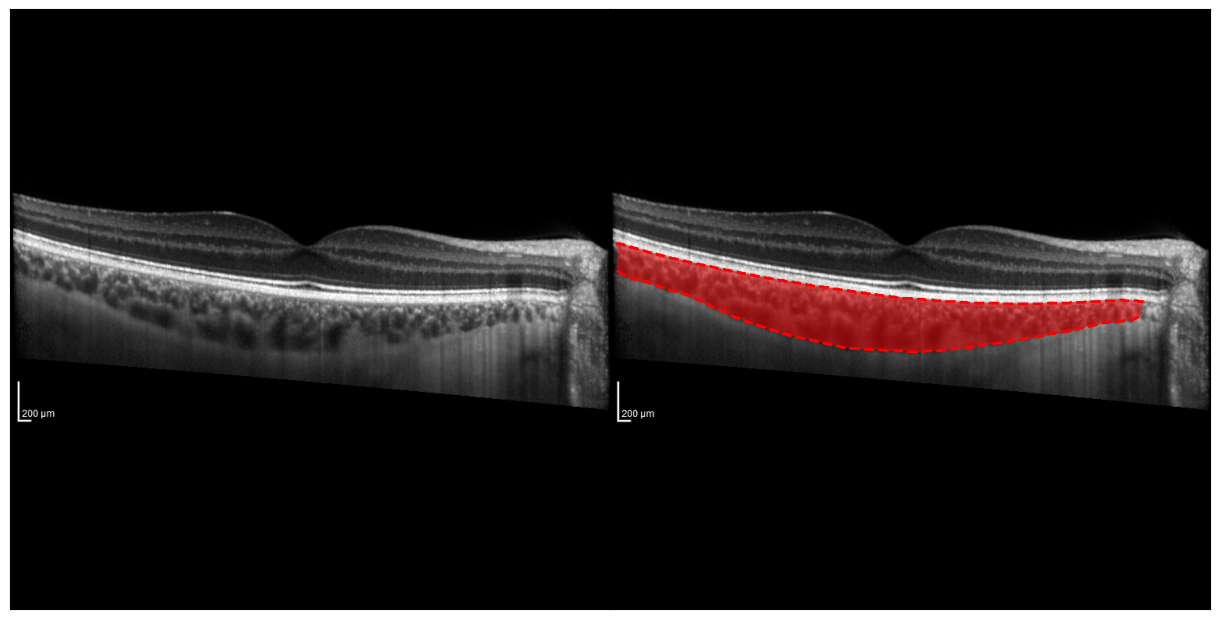

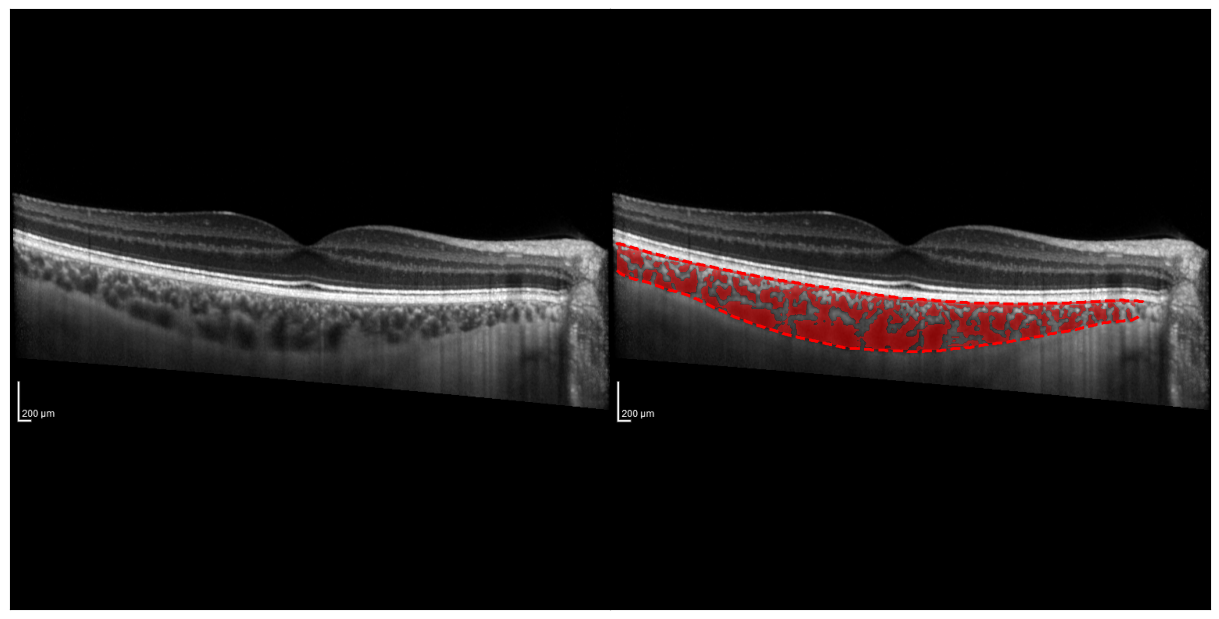

In [1]:
# Load choroid region and vessel segmentation libraries
from pathlib import Path
from choves import segment, utils
from choves.metrics import choroid_metrics, choroid_utils
from choseg import inference

# Load image
example_path = Path("notebooks/example_data")
img_path = example_path / "image1.png" #"path\to\img"
img = utils.load_img(img_path)

# Instantiate inference class for DeepGPET
deepgpet = inference.DeepGPET()

# Segment region with DeepGPET
img_regseg = deepgpet(img)
img_bounds = utils.get_trace(img_regseg) # Detects the upper and lower choroid boundaries based on the mask

# Plot region segmentation superimposed onto image
utils.plot_img(img, traces=img_bounds, cmap=utils.generate_imgmask(img_regseg), sidebyside=True) # Plots the image, trace and segmentation colour map

# Segment vessels with MMCQ
img_vesseg = segment.segment_vessels(img, img_bounds)

# Plot vessel segmentation superimposed onto image
utils.plot_img(img, traces=img_bounds, cmap=utils.generate_imgmask(img_vesseg), sidebyside=True) # Plots the image, trace and segmentation colour map

# Measure the choroid
choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg)
# thickness (microns) temporal, subfoveal and nasal (190, 290, 130), area 1.374898mm2, vascular index 0.62044, vessel area 0.853041mm2

---
# Segmenting the choroid

To segment the choroid, we use DeepGPET to obtain the choroid region and MMCQ to segment the choroidal vessels. 

For MMCQ's call `segment.vessel_seg` there is one optional parameter called `seg_params`. This is a 2-tuple which stores the total number of groups to cluster the pixels in after the choroid has been enhanced, and the number of cluster groups to keep and assign as vessel. In our experience, the default setting of `seg_params=(10,5)`, i.e. 10 cluster groups and the 5 groups to assign as vessel has worked well. Sometimes, particularly if the choroid is large and there are large vessels, you might consider increasing the second value, i.e. to `seg_params=(10,6)`. Feel free to experiment!

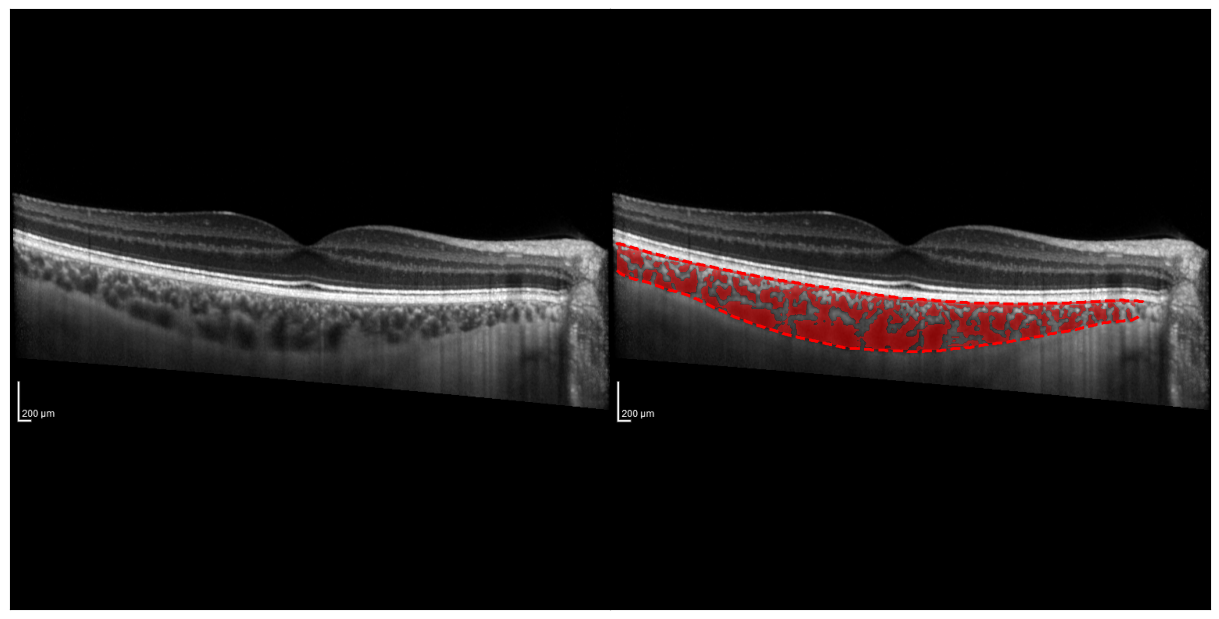

In [2]:
# Load image
example_path = Path("notebooks/example_data")
img_path = example_path / "image1.png" #"path\to\img"
img = utils.load_img(img_path)

# Segment
img_regseg = deepgpet(img)
img_regtraces = utils.get_trace(img_regseg)
img_vesseg = segment.segment_vessels(img, img_regtraces)

utils.plot_img(img, traces=img_bounds, cmap=utils.generate_imgmask(img_vesseg), sidebyside=True)

---
# Measuring the choroid

To measure the choroid, there are a few inputs available to customise how and what you want to measure in the choroid. Note that the input `plottable` conveniently outputs a binary mask of the region of interest used to measure choroid area, and the points along the upper and lower bounds of the choroid segmentation which were used to measure choroid thickness. `plottable=False` only outputs the thickness and area values.

### Fovea
In our experience, knowing the location of the `fovea` in the OCT B-scan helps centre a region of interest on the scan and standardises the measurements you make, particularly if doing so across a cohort.


##### Selecting your own Fovea

If you do not know the location of the fovea, the function will take the midpoint of the segmentation and use that. This repository stores a simple, openCV-based GUI implementation for you to select the fovea for a series of images, check out `notebooks/demo_pixel_gui.ipynb`.

In [3]:
import pandas as pd
from choseg.metrics import choroid_utils
import matplotlib.pyplot as plt

In [4]:
# It's only important to get the column index of the fovea, the row doesn't matter so much
# choroid_utils.select_pixels(img, scale=800, save_path="example_data", fname=f"example_fovea_test", cmap=None)() # Uncomment this to use the simple GUI and overwrite example_fovea.csv with your own fovea!
fovea_path = example_path / "example_fovea.csv" #"path\to\img"
fovea = pd.read_csv(fovea_path).values[0]

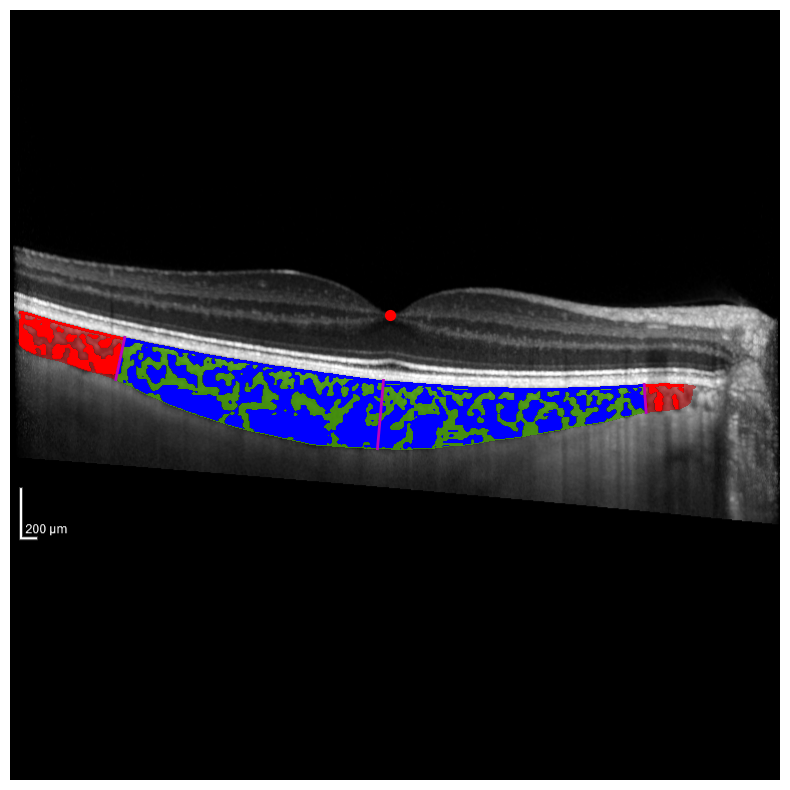

In [5]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, plottable=True)
# thickness (193, 272, 111), area 1.357734mm2, vascular index 0.61741, vessel area 0.838279mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="m", linewidth=2) # thickness measurements (magenta)
ax.set_axis_off()

### Scaling

OCT imaging devices provide an exact conversion factor from pixel space into physical space. This is typically in units microns-per-pixel. This changes depending on the size of the eye and degree of myopia. For an emmetropic individual, the Heidelberg imaging device default setting is `11.48 microns-per-pixel` in the `x` direction, and `3.87 microns-per-pixel` in the `y`-direction. This is coded as `scale=(11.48,3.87)`. 

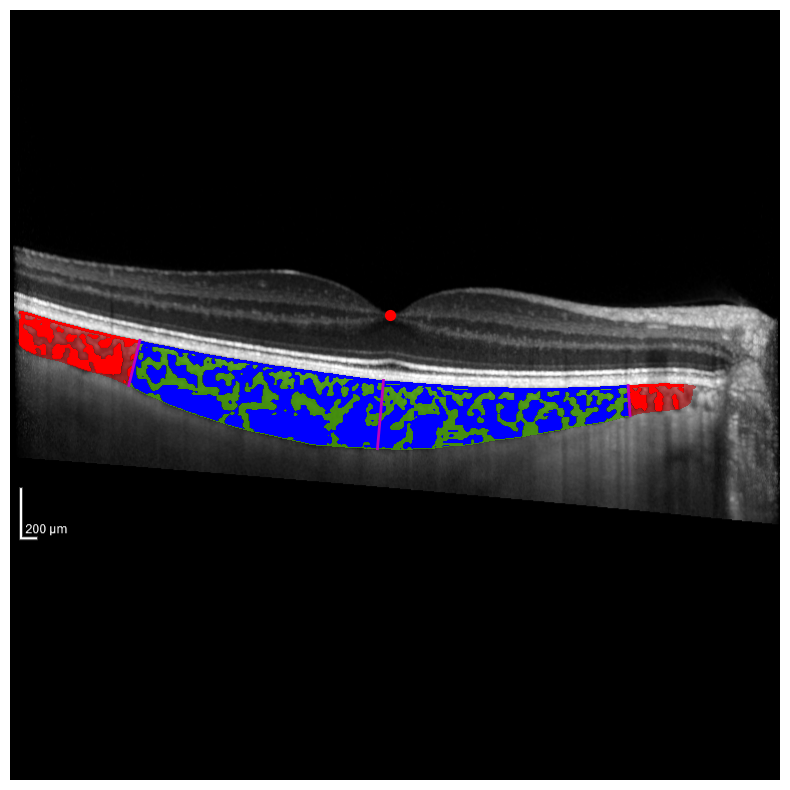

In [6]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, scale=(12.24, 3.21), plottable=True) # set random scale for example
# thickness (197, 230,  99), area 1.154863mm2, vascular index 0.62141, vessel area 0.717639mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="m", linewidth=2) # thickness measurements (magenta)
ax.set_axis_off()

### Region of interest

You can also specify the size of the region of interest using `macula_rum`, which represents the micron distance either side of the fovea.  By default `macula_rum=3000` microns, i.e. 3mm distance either side of the fovea, so a 6mm region of interest in total.

Moreover, on occasion the Choroid may appear skewed relative to the image axis, and so the region of interest is measured corresponding to the choroid axis by default to account for this curvature, and the measurements are made locally perpendicular to this axis. This can be changed to measure according to the image axis if preferred using `measure_type` and `measure_axis`. This means that choroid thickness is measured as a vertical line distance, and the region of interest is defined using the image axis, not the choroid axis.

The default setting here is `measure_type="perpendicular"` and `measure_axis=choroid`. In this case, the `offset` parameter is the number of pixel columns to define the tangential line around each location where the region of interest ends and measures thickness, so that a locally perpendicular line can be drawn.

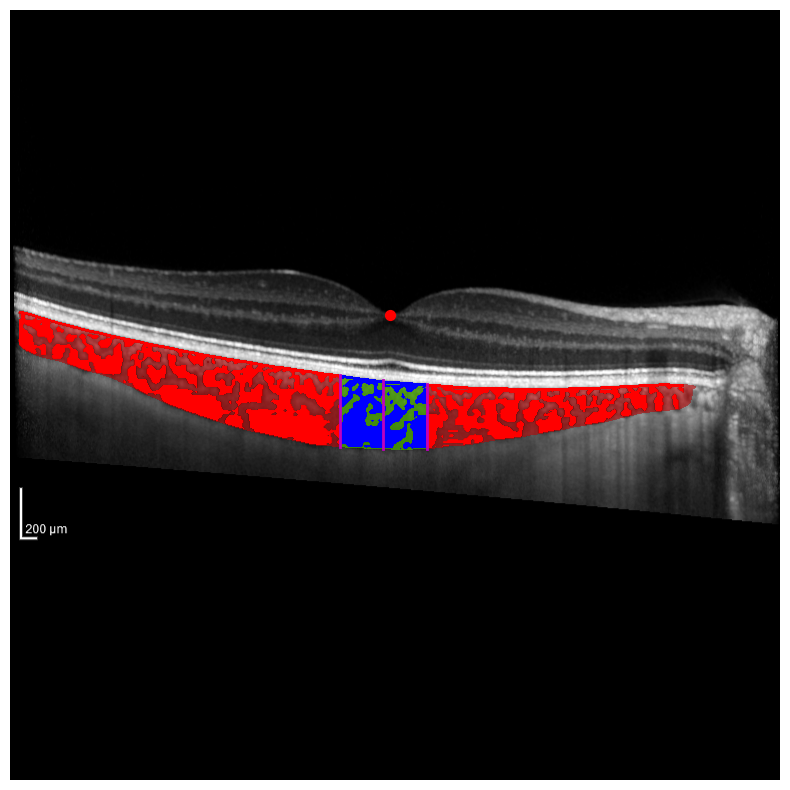

In [7]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, scale=(11.48, 3.87), macula_rum=500, 
                                                                                             measure_type='vertical', measure_axis='image', plottable=True)
# thickness (275, 263, 248), area 0.264344mm2, vascular index 0.6521, vessel area 0.172379mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="m", linewidth=2) # thickness measurements (magenta)
ax.set_axis_off()

### Thickness measurements

You can also measure thickness values at several locations (and subfoveal by default) by specifying `N_measures`. Moreover, to robustly measure thickness you can use the `N_avgs` input to specify how many thickness measurements to be made at adjacent position for each locations.

For example, `N_measures=3` and `N_avgs=4` implies that we measure thickness at three locations, subfoveal and `macula_rum` microns temporal and nasal to the fovea. For each location, we measure thickness at the location, and at 2 columns either side of this point, and average the value.

## Robust measurement

Sometimes the segmentation might not be wide enough to measure the region of interst specified, i.e. if `macula_rum=8000`, i.e. 8mm either side of the fovea, this will not work and will output zeros. Setting `verbose=1` can warn the user of this.

Moreover, if your segmentation is unable to measure according to your input parameters, it will try it's best to accommodate them through setting `force_measurement=True`. 

In [8]:
choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, scale=(11.48, 3.87), macula_rum=8000, N_measures=3, N_avgs=5,
                                            measure_type='perpendicular', measure_axis='choroid', plottable=True, verbose=1)
# thickness (0, 0, 0), area 0mm2, vascular index 0, vessel area 0mm2 as it cannot measure this macula_rum

                    Extend segmentation or reduce macula_rum to prevent this from happening.
                    Returning 0s.


(array([0, 0, 0]), 0, 0, 0)

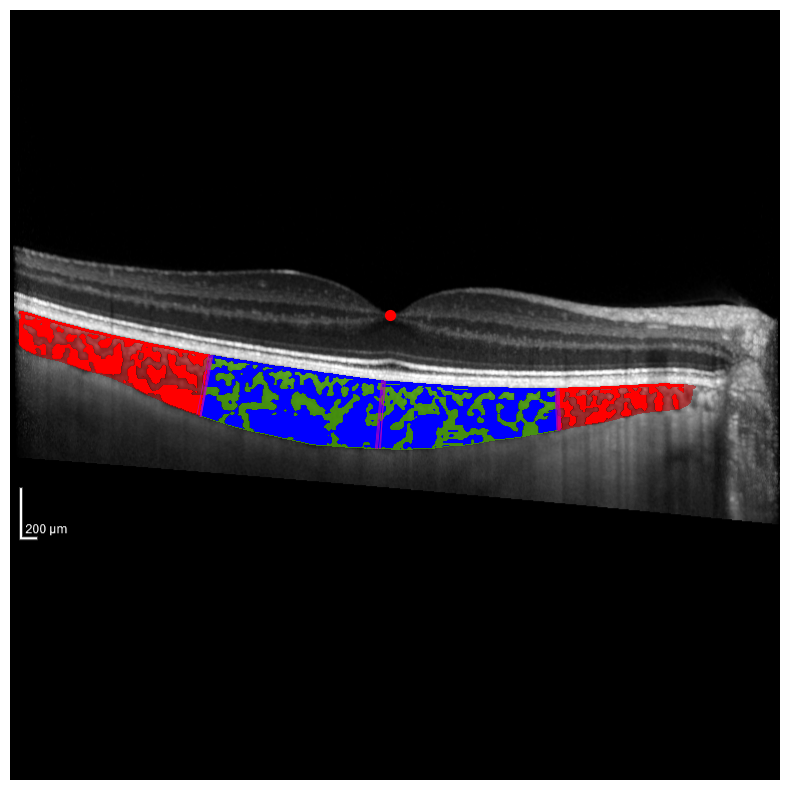

In [9]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, scale=(11.48, 3.87), macula_rum=2000, N_measures=3, N_avgs=4,
                                                                          measure_type='perpendicular', measure_axis='choroid', plottable=True)
# thickness (268, 270, 163), area 1.003175mm2, vascular index 0.63189, vessel area 0.633893mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="m", linewidth=0.5) # thickness measurements (magenta)
ax.set_axis_off()

            Reducing right-endpoint reference point by 8 pixels.
            Extend segmentation or reduce macula_rum/N_avgs/offset to prevent under-measurement.


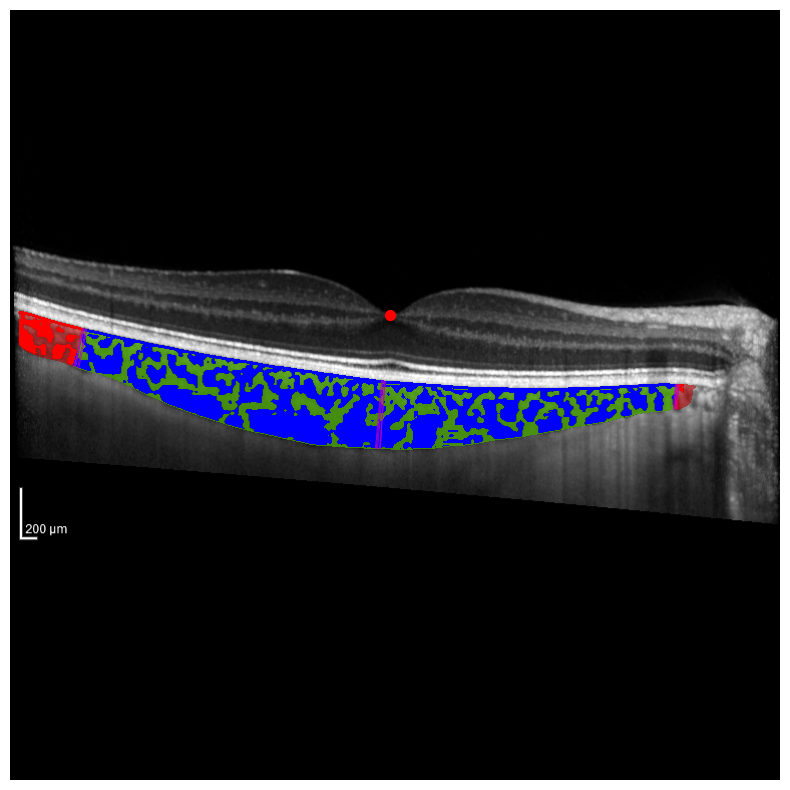

In [10]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, img_vesseg, fovea=fovea, scale=(11.48, 3.87), macula_rum=3465, N_measures=3, N_avgs=4,
                                                                          measure_type='perpendicular', measure_axis='choroid', plottable=True, verbose=1, force_measurement=True)
# thickness (177, 270, 100), area 1.472064mm2, vascular index 0.61318, vessel area 0.903346mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="m", linewidth=0.5) # thickness measurements (magenta)
ax.set_axis_off()

---
## Putting it all together

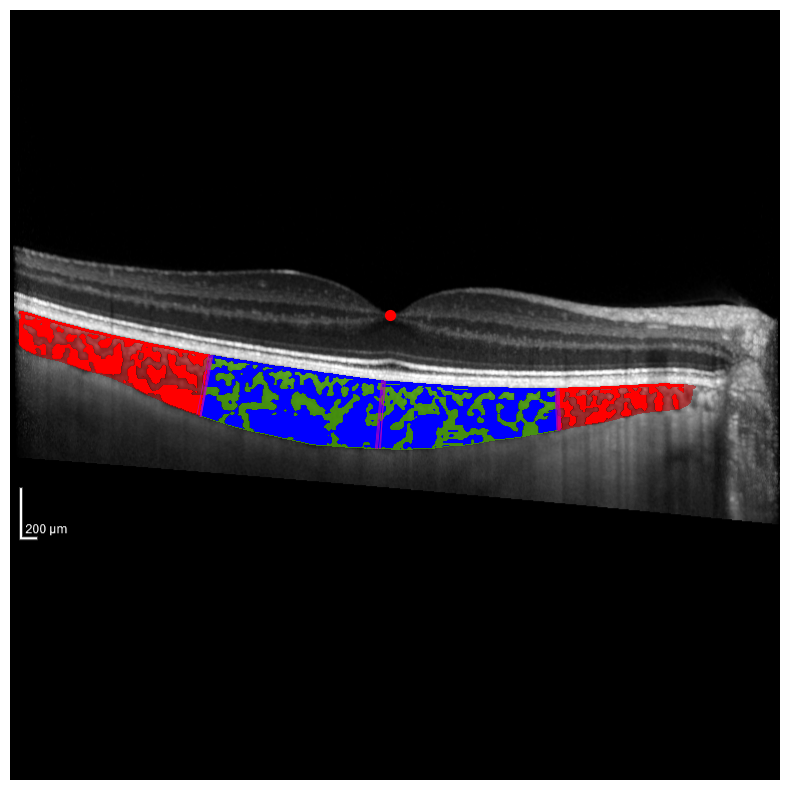

In [11]:
(ct, ca, cvi, va), (ct_pts, ca_mask, cvi_mask) = choroid_metrics.compute_choroid_measurement(img_regseg, 
                                                                                              img_vesseg, 
                                                                                              fovea=fovea, 
                                                                                              scale=(11.48, 3.87), 
                                                                                              macula_rum=2000, 
                                                                                              N_measures=3, 
                                                                                              N_avgs=4,
                                                                                              offset=15,
                                                                                              measure_type='perpendicular', 
                                                                                              measure_axis='choroid',
                                                                                              plottable=True, 
                                                                                              verbose=0, 
                                                                                              force_measurement=False)
# thickness (268, 270, 163), area 1.003175mm2, vascular index 0.63189, vessel area 0.633893mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(0.75*utils.generate_imgmask(img_regseg,None,0), alpha=0.75) # region segmentation mask (dark red)
ax.imshow(utils.generate_imgmask(img_vesseg,None,0), alpha=1) # vessel segmentation mask (bright red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.imshow(utils.generate_imgmask(cvi_mask,None,2)) # vessels of interest (blue)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="m", linewidth=0.5) # thickness measurements (magenta)
ax.set_axis_off()